In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [116]:
# build dataset

def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [16]:
# Build embedding lookup table

C = torch.randn((27, 2))
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.4968, -0.9732])

In [26]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [28]:
# Construct hidden layer
W1 = torch.randn((6, 100))
b1 = torch.randn(100)


In [34]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

In [57]:
emb.shape

torch.Size([32, 3, 2])

In [36]:
h.shape

torch.Size([32, 100])

In [38]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [39]:
logits = h @ W2 + b2

In [40]:
logits.shape

torch.Size([32, 27])

In [41]:
counts = logits.exp()

In [42]:
prob = counts / counts.sum(1, keepdims=True)

In [43]:
prob.shape

torch.Size([32, 27])

In [50]:
loss = -prob[torch.arange(32), Y].log().mean()

tensor([1.4693e-15, 2.8444e-14, 1.4192e-15, 3.3873e-05, 1.4672e-04, 5.8428e-06,
        4.0476e-06, 5.0316e-03, 8.4302e-13, 1.8043e-03, 1.5560e-13, 1.2471e-07,
        4.3982e-15, 3.9242e-10, 4.2860e-06, 7.1434e-06, 9.9999e-01, 1.1862e-04,
        1.8731e-02, 3.9354e-12, 5.1785e-08, 9.9709e-01, 1.8958e-07, 9.2727e-06,
        3.2205e-07, 7.5272e-16, 9.9141e-01, 9.2202e-11, 3.2399e-14, 5.4021e-04,
        5.2464e-09, 3.4402e-10])

In [51]:
# cleaner version

In [117]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [156]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [157]:
sum(p.nelement() for p in parameters)

11897

In [158]:
for p in parameters:
    p.requires_grad = True

In [141]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [142]:
Xdev.shape

torch.Size([22767, 3])

In [161]:
lri = []
lossi = []
stepi = []

In [174]:


for i in range(200000):

    # minibatch construction
    ix = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass 
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())

# print(loss.item())


In [175]:
print(loss.item())

2.4139208793640137


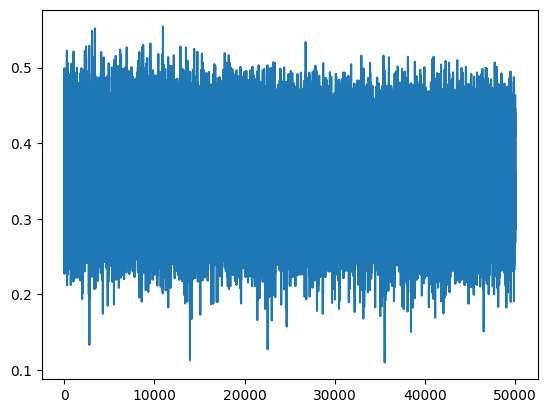

In [167]:
plt.plot(stepi, lossi)

In [168]:
torch.randint(0, X.shape[0], (32,))

tensor([167168, 209655, 227631, 123344,  42178,  63298,  38100, 124597,  97324,
        158663, 117864, 168431, 142959, 170713, 159445,  11665,  34884,  92365,
         75234, 142016, 143975,  88374, 115172, 172949, 198654,   2754, 207633,
        202688,  12253, 105845, 149992,  94849])

In [176]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2490, grad_fn=<NllLossBackward0>)

In [ ]:
# training split, dev/validation split, test split
# 80, 10, 10



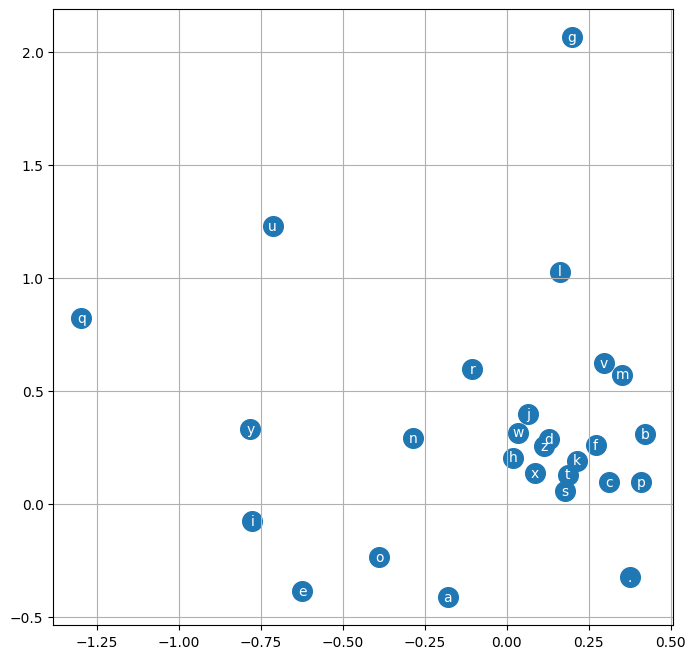

In [155]:
# visualize embedding space

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")

plt.grid('minor')

In [179]:
# sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(list(''.join(itos[i]) for i in out))

['c', 'a', 'r', 't', 'a', '.']
['f', 'a', 't', 'o', '.']
['h', 'a', 'r', 'i', '.']
['k', 'e', 'm', 'r', 'i', 'i', '.']
['t', 'a', 't', 'y', '.']
['s', 'a', 'c', 'e', '.']
['s', 'a', 'l', '.']
['r', 'a', 'h', 'n', 'e', 'n', '.']
['d', 'e', 'l', 'i', 'a', 'h', '.']
['j', 'a', 'c', 'q', 'u', 'i', '.']
['d', 'e', 'r', '.']
['d', 'e', 'a', '.']
['c', 'h', 'a', 'i', 'i', 'r', '.']
['d', 'a', 'l', 'e', 'i', 'g', 'h', '.']
['h', 'a', 'm', '.']
['j', 'o', 'c', 'a', '.']
['q', 'u', 'i', 'n', 't', 'i', 's', '.']
['l', 'i', 'l', '.']
['d', 'e', 'v', 'i', 'a', 'n', 'a', '.']
['w', 'a', 'z', 'e', 'l', '.']
